# Car Insurance Claims Classification Project

In this classification project, we are using machine learning models to predict whether a car insurance claim was filed by a policyholder based on their given traits. The goal of this notebook is to explore and analyze the given data, preprocess the data, and then fit the data on the best performing model and hypertune its parameters. The purpose of this project is to help automate the insurance application process, optimize pricing strategies by better assessing risk, and analyze which traits are desirable in future policyholders. 

The dataset used in this project is from: https://www.kaggle.com/datasets/sagnik1511/car-insurance-data

## Data Overview 

This dataset contains 10,000 records of car insurance policyholders

Our target variable is the claim_made (originally OUTCOME) feature, which represents whether a car insurance claim was made or not by the policyholder

Features include:

**Demographic Information:** Age, gender, education, income, etc.

**Vehicle Specifications:** Ownership, vehicle year, annual mileage, etc.

**Driving Record:** History of duis, speeding violations, past accidents

## Objective

We are trying to predict whether a claim has been filed based on given features of policyholders

We will achieve this through five main steps:

#### 1. Data Overview
#### 2. Exploratory Data Analysis
#### 3. Data Cleaning and Preprocessing
#### 4. Creating Model Pipeline
#### 5. Model Testing 

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import power_transform
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [3]:
csv = r"Car_Insurance_Claim.csv"

claims = pd.read_csv(csv, delimiter = ",")
claims.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [4]:
claims.shape

(10000, 19)

## 1. Data Overview

#### 1.1 Basic data cleaning and inspection

In [6]:
# Create copy of original dataset
claims_copy = claims.copy()

In [7]:
# Renaming columns
new_name_dict = {"ID": "id", "AGE": "age", "GENDER": "gender", "RACE": "race", "DRIVING_EXPERIENCE": "driving_experience", 
                 "EDUCATION": "education_level", "INCOME": "income_level", "CREDIT_SCORE": "credit_score", 
                 "VEHICLE_OWNERSHIP": "vehicle_owned", "VEHICLE_YEAR": "vehicle_year", "MARRIED": "is_married",
                 "CHILDREN": "has_children", "POSTAL_CODE": "postal_code", "ANNUAL_MILEAGE": "annual_mileage",
                 "VEHICLE_TYPE": "vehicle_type", "SPEEDING_VIOLATIONS": "num_speeding_violations", 
                 "DUIS": "num_duis", "PAST_ACCIDENTS": "num_past_accidents", "OUTCOME": "claim_made"}

claims_copy.rename(columns = new_name_dict, inplace = True)

In [8]:
claims_copy.head()

,id,age,gender,race,driving_experience,education_level,income_level,credit_score,vehicle_owned,vehicle_year,is_married,has_children,postal_code,annual_mileage,vehicle_type,num_speeding_violations,num_duis,num_past_accidents,claim_made
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [9]:
# Checking if id feature is unique identifier
claims_copy["id"].is_unique

True

In [10]:
# Dropping unique identifier column id
claims_copy = claims_copy.drop(columns = "id")

In [11]:
claims_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      10000 non-null  object 
 1   gender                   10000 non-null  object 
 2   race                     10000 non-null  object 
 3   driving_experience       10000 non-null  object 
 4   education_level          10000 non-null  object 
 5   income_level             10000 non-null  object 
 6   credit_score             9018 non-null   float64
 7   vehicle_owned            10000 non-null  float64
 8   vehicle_year             10000 non-null  object 
 9   is_married               10000 non-null  float64
 10  has_children             10000 non-null  float64
 11  postal_code              10000 non-null  int64  
 12  annual_mileage           9043 non-null   float64
 13  vehicle_type             10000 non-null  object 
 14  num_speeding_violations

In [12]:
# Convert postal_code column to string datatype instead of integer
claims_copy["postal_code"] = claims_copy["postal_code"].astype(str)

In [13]:
# Checking for duplicates 
claims_copy.duplicated().sum()

12

In [14]:
# Dropping duplicate rows
claims_copy.drop_duplicates(inplace = True)

In [15]:
claims_copy.shape

(9988, 18)

In [16]:
claims_copy.describe()

,credit_score,vehicle_owned,is_married,has_children,annual_mileage,num_speeding_violations,num_duis,num_past_accidents,claim_made
count,9018.000000,9988.000000,9988.000000,9988.000000,9034.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,0.515813,0.697537,0.498698,0.689327,11694.598185,1.484581,0.239487,1.057369,0.312775
std,0.137688,0.459348,0.500023,0.462792,2818.004386,2.242766,0.555262,1.653047,0.463647
min,0.053358,0.000000,0.000000,0.000000,2000.000000,0.000000,0.000000,0.000000,0.000000
25%,0.417191,0.000000,0.000000,0.000000,10000.000000,0.000000,0.000000,0.000000,0.000000
50%,0.525033,1.000000,0.000000,1.000000,12000.000000,0.000000,0.000000,0.000000,0.000000
75%,0.618312,1.000000,1.000000,1.000000,14000.000000,2.000000,0.000000,2.000000,1.000000
max,0.960819,1.000000,1.000000,1.000000,22000.000000,22.000000,6.000000,15.000000,1.000000


In [17]:
claims_copy.describe(include="object")

,age,gender,race,driving_experience,education_level,income_level,vehicle_year,postal_code,vehicle_type
count,9988,9988,9988,9988,9988,9988,9988,9988,9988
unique,4,2,2,4,3,4,2,4,2
top,26-39,female,majority,0-9y,high school,upper class,before 2015,10238,sedan
freq,3062,5003,9000,3519,4151,4335,6955,6929,9511


In [18]:
# Check for null values in columns
np.sum(claims_copy.isnull())

age                          0
gender                       0
race                         0
driving_experience           0
education_level              0
income_level                 0
credit_score               970
vehicle_owned                0
vehicle_year                 0
is_married                   0
has_children                 0
postal_code                  0
annual_mileage             954
vehicle_type                 0
num_speeding_violations      0
num_duis                     0
num_past_accidents           0
claim_made                   0
dtype: int64

In [19]:
# Check for class inbalance in the target feature
postive_claim_count = 0
negative_claim_count = 0

for i in range(len(claims_copy["claim_made"])):
    if claims_copy["claim_made"].iloc[i] == 1:
        postive_claim_count += 1
    else:
        negative_claim_count += 1

print(f"Positive claims: {postive_claim_count}")
print(f"Negative claims: {negative_claim_count}")

Positive claims: 3124
Negative claims: 6864


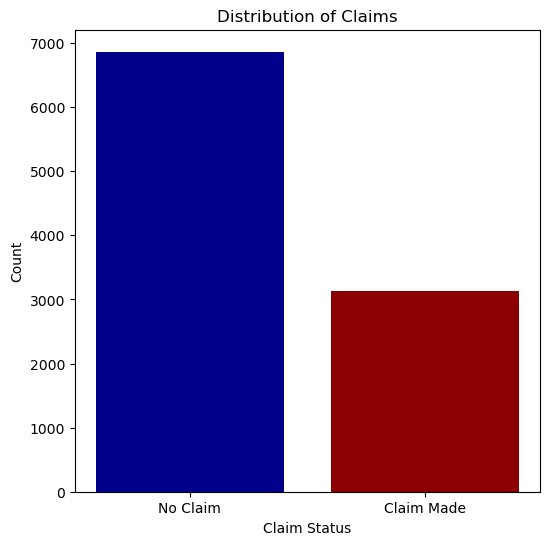

In [20]:
# Plot distribution of claims
claim_counts = claims_copy["claim_made"].value_counts().reindex([0.0, 1.0])

plt.figure(figsize=(6, 6))
plt.bar(claim_counts.index, claim_counts.values, color=["darkblue", "darkred"])
plt.xlabel("Claim Status")
plt.ylabel("Count")
plt.title("Distribution of Claims")

plt.xticks([0, 1], labels=["No Claim", "Claim Made"])

plt.show()

Since this dataset has a class imbalance in the target feature (claims made vs not made), we will utilize stratified sampling while splitting our data

Later, we will also use oversampling on our training set to fit the data without the class imbalance

#### 1.2 Creating Training/Test Split

In [23]:
# Creating training test split while stratifying by driving experience
X = claims_copy.copy()
y = claims_copy["claim_made"]

# Dropping target feature
X = X.drop(columns = "claim_made", inplace = False)

# Creating training test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = claims_copy["claim_made"], random_state = 42)

In [24]:
# Checking whether the distribution of claims made/not made is relatively equal between training and test sets 
training_label_distrib = y_train.value_counts() / len(y_train)
test_label_distrib = y_test.value_counts() / len(y_test)

print(training_label_distrib)
print(test_label_distrib)

claim_made
0.0    0.687234
1.0    0.312766
Name: count, dtype: float64
claim_made
0.0    0.687187
1.0    0.312813
Name: count, dtype: float64


## 2. Exploratory Data Analysis

#### 2.1 Sorting features

In [26]:
# Creating a copy of training set for EDA
eda_data = X_train.copy()
eda_data["claim_made"] = y_train

In [27]:
# Exploring numeral type column values
for col in eda_data.select_dtypes(include=[np.number]).columns:
    print(eda_data[col].value_counts())

credit_score
0.378046    1
0.588605    1
0.488311    1
0.326033    1
0.623790    1
           ..
0.581499    1
0.578371    1
0.125896    1
0.430522    1
0.670803    1
Name: count, Length: 7207, dtype: int64
vehicle_owned
1.0    5617
0.0    2373
Name: count, dtype: int64
is_married
0.0    4030
1.0    3960
Name: count, dtype: int64
has_children
1.0    5512
0.0    2478
Name: count, dtype: int64
annual_mileage
12000.0    989
11000.0    984
13000.0    924
10000.0    836
14000.0    720
9000.0     688
15000.0    511
8000.0     456
16000.0    330
7000.0     259
17000.0    196
6000.0     133
18000.0     86
5000.0      52
19000.0     35
4000.0      17
20000.0     11
3000.0       7
22000.0      2
2000.0       2
Name: count, dtype: int64
num_speeding_violations
0     4029
1     1238
2      916
3      669
4      420
5      250
6      148
7      110
8       64
10      43
9       40
11      25
12      12
13       9
15       6
14       4
16       3
17       1
18       1
22       1
19       1
Name: cou

Binary numerical columns: is_married, has_children, vehicle_owned, claim_made

Unique numerical columns: credit_score, annual_mileage, num_speeding_violations, num_duis, num_past_accidentschildren

In [29]:
# Exploring object type columns and their values 
for col in eda_data.select_dtypes(include=[object]).columns:
    print(eda_data[col].value_counts())

age
26-39    2473
40-64    2324
16-25    1599
65+      1594
Name: count, dtype: int64
gender
female    4011
male      3979
Name: count, dtype: int64
race
majority    7212
minority     778
Name: count, dtype: int64
driving_experience
0-9y      2812
10-19y    2648
20-29y    1682
30y+       848
Name: count, dtype: int64
education_level
high school    3318
university     3141
none           1531
Name: count, dtype: int64
income_level
upper class      3453
middle class     1708
poverty          1450
working class    1379
Name: count, dtype: int64
vehicle_year
before 2015    5556
after 2015     2434
Name: count, dtype: int64
postal_code
10238    5571
32765    1932
92101     399
21217      88
Name: count, dtype: int64
vehicle_type
sedan         7624
sports car     366
Name: count, dtype: int64


Binary Categorical Columns: gender, race, vehicle_year, vehicle_type

Ordinal Categorical Columns: driving_experience, education_level, income_level

Nominal Categorical Columns: age, postal_code

In [31]:
# Transform binary object columns into having numerical values before exploratory data analysis
binary_cols = ["gender", "race", "vehicle_year", "vehicle_type"]

mapping = {"male": 1,
           "female": 0,
           "minority": 1,
           "majority": 0,
           "after 2015": 1,
           "before 2015": 0,
           "sports car": 1,
           "sedan": 0}

def binarize_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

binarize_values(eda_data, binary_cols, mapping)

,age,gender,race,driving_experience,education_level,income_level,credit_score,vehicle_owned,vehicle_year,is_married,has_children,postal_code,annual_mileage,vehicle_type,num_speeding_violations,num_duis,num_past_accidents,claim_made
1310,26-39,1,0,10-19y,none,working class,0.378046,0.0,1,0.0,0.0,10238,13000.0,0,2,1,3,0.0
156,16-25,0,0,0-9y,none,poverty,NaN,0.0,0,0.0,0.0,21217,14000.0,0,0,0,0,1.0
3581,65+,0,0,0-9y,university,upper class,0.590250,1.0,1,1.0,1.0,10238,12000.0,0,0,0,0,0.0
3322,26-39,0,0,10-19y,university,upper class,0.747843,1.0,0,1.0,1.0,32765,13000.0,0,1,0,0,0.0
8547,65+,1,0,0-9y,high school,upper class,0.730233,1.0,0,0.0,0.0,32765,11000.0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,26-39,0,0,0-9y,high school,working class,0.420189,0.0,1,1.0,1.0,10238,9000.0,0,0,0,0,1.0
3135,16-25,1,0,0-9y,none,working class,0.583197,1.0,0,0.0,1.0,10238,NaN,0,0,0,0,1.0
1822,16-25,0,0,0-9y,high school,poverty,0.326029,0.0,0,1.0,0.0,10238,19000.0,0,0,0,0,1.0
9259,16-25,0,0,0-9y,none,working class,0.382970,1.0,1,1.0,0.0,10238,14000.0,0,0,0,0,0.0


#### 2.2 Analyzing Categorical Features

Let's analyze how some promising categorical features and how they are correlated to the claim_made column:

education_level
none           0.191615
high school    0.415269
university     0.393116
Name: count, dtype: float64

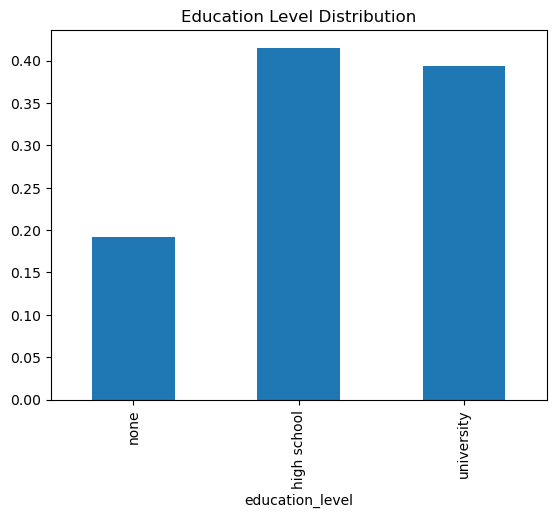

education_level
none           0.089487
high school    0.132290
university     0.090989
Name: count, dtype: float64

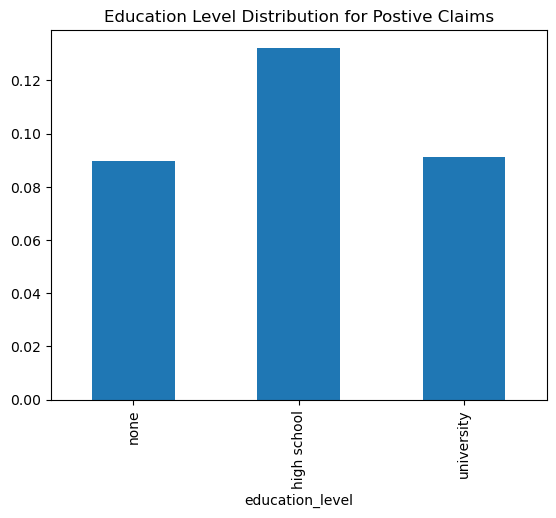

In [33]:
# Comparing education level to education level when a claim is made

# Number of rows in the data
num_rows = eda_data.shape[0]

#Sorting education level in ascending order
edu_order = ["none", "high school", "university"]
eda_data["education_level"] = pd.Categorical(eda_data["education_level"], categories=edu_order, ordered=True)
edu_vals = eda_data["education_level"].value_counts(sort=False)

#Plotting distribution
display(edu_vals / num_rows)
(edu_vals / num_rows).plot(kind="bar")
plt.title("Education Level Distribution")
plt.show()

# Extracting/plotting education_level distribution when a claim is made
pos_claims_edu = eda_data[eda_data["claim_made"] == 1]["education_level"].value_counts(sort=False)
display(pos_claims_edu / num_rows)
(pos_claims_edu / num_rows).plot(kind="bar")
plt.title("Education Level Distribution for Postive Claims")
plt.show()

Our bar charts show a weak-moderate correlation between higher education level and lower chances of filing a claim

Now let's see how income level is correlated in these circumstances

income_level
poverty          0.181477
working class    0.172591
middle class     0.213767
upper class      0.432165
Name: count, dtype: float64

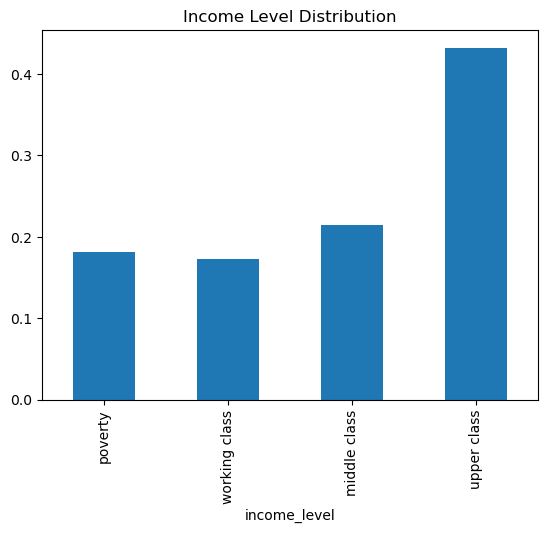

income_level
poverty          0.117146
working class    0.078223
middle class     0.059825
upper class      0.057572
Name: count, dtype: float64

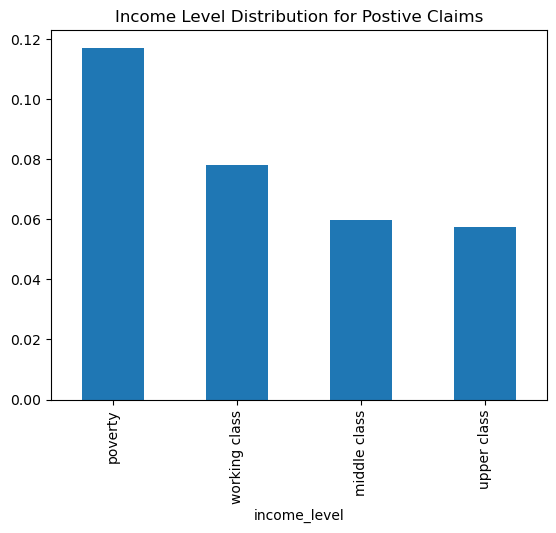

In [35]:
# Comparing income distribution to income distribution when a claim is made
income_order = ["poverty", "working class", "middle class", "upper class"]
eda_data["income_level"] = pd.Categorical(eda_data["income_level"], categories=income_order, ordered=True)
income_vals = eda_data["income_level"].value_counts(sort=False)

#Plotting distribution
display(income_vals / num_rows)
(income_vals / num_rows).plot(kind="bar")
plt.title("Income Level Distribution")
plt.show()

# Extracting/plotting education_level distribution when a claim is made
pos_claims_income = eda_data[eda_data["claim_made"] == 1]["income_level"].value_counts(sort=False)
display(pos_claims_income / num_rows)
(pos_claims_income / num_rows).plot(kind="bar")
plt.title("Income Level Distribution for Postive Claims")
plt.show()

The graphs indicate a moderately strong correlation between increased income level and decreased likelehood of filing a claim

We'll try vehicle year next:

vehicle_year
before 2015    0.695369
after 2015     0.304631
Name: count, dtype: float64

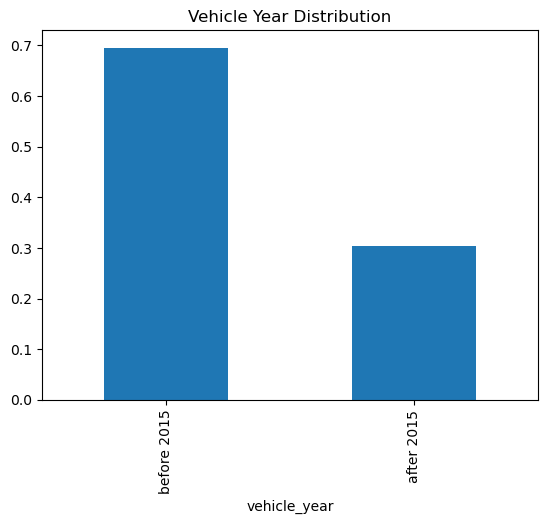

vehicle_year
before 2015    0.281602
after 2015     0.031164
Name: count, dtype: float64

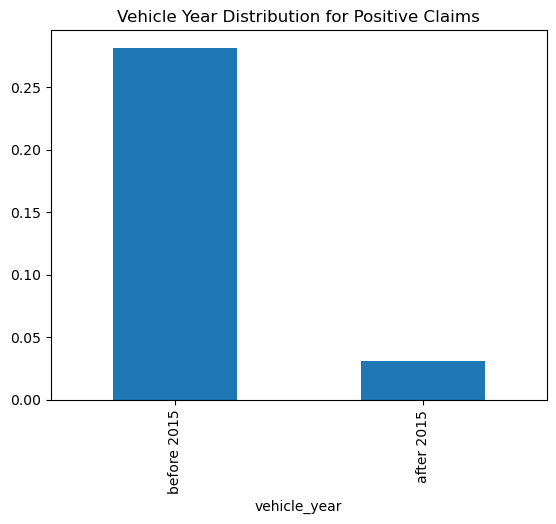

In [37]:
year_labels = {0: "before 2015", 1: "after 2015"}
eda_data["vehicle_year"] = pd.Categorical(
    eda_data["vehicle_year"].map(year_labels), categories=year_labels.values(), ordered=True
)
year_vals = eda_data["vehicle_year"].value_counts(sort=False)

#Plotting distribution
display(year_vals / num_rows)
(year_vals / num_rows).plot(kind="bar")
plt.title("Vehicle Year Distribution")
plt.show()

#Extracting/plotting vehicle year distribution when a claim is made
pos_claims_year = eda_data[eda_data["claim_made"] == 1]["vehicle_year"].value_counts(sort=False)

# Plotting the distribution for positive claims
display(pos_claims_year / num_rows)
(pos_claims_year / num_rows).plot(kind="bar")
plt.title("Vehicle Year Distribution for Positive Claims")
plt.show()

It seems that vehicle year of after 2015 is strongly correlated with smaller chance of filing a claim

Next, we will assess postal codes:

postal_code
10238    0.697247
32765    0.241802
92101    0.049937
21217    0.011014
Name: count, dtype: float64

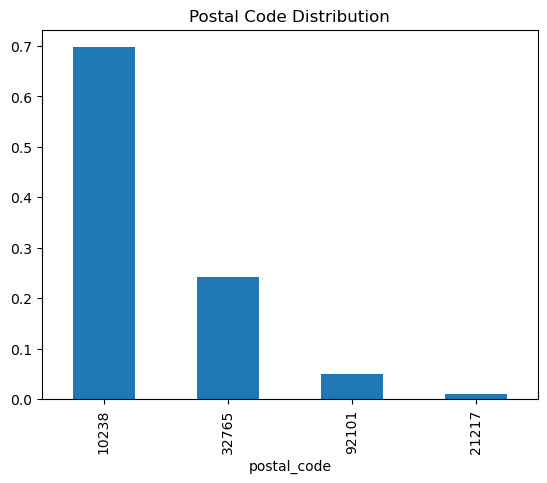

postal_code
10238    0.190113
32765    0.090738
92101    0.020901
21217    0.011014
Name: count, dtype: float64

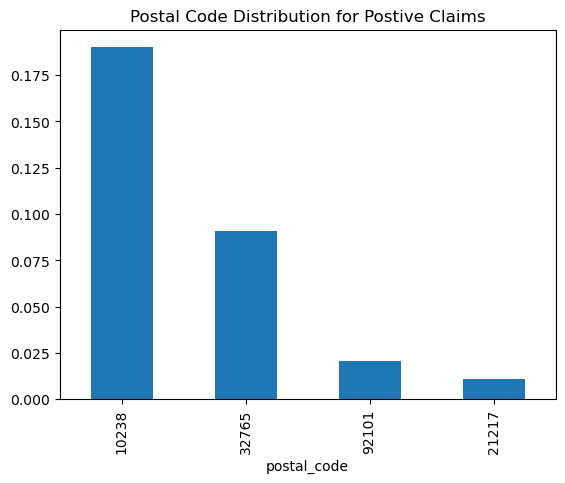

In [39]:
# Comparing postal code distribution versus postal code distribution for postive claims

postal_code_vals = eda_data["postal_code"].value_counts()
display(postal_code_vals / num_rows)
(postal_code_vals / num_rows).plot(kind="bar")
plt.title("Postal Code Distribution")
plt.show()

pos_claims_postal = eda_data[eda_data["claim_made"] == 1]["postal_code"].value_counts()
display(pos_claims_postal / num_rows)
(pos_claims_postal / num_rows).plot(kind="bar")
plt.title("Postal Code Distribution for Postive Claims")
plt.show()

In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.output_scroll { height: auto; }</style>"))

Postal code does not seem to be correlated with positive claims

Next feature we'll check is age

**Note:** Postal Code 21217 has an 100% positive claim rate, but I'm assuming that is because of bias data collection from that particular postal code

age
16-25    0.200125
26-39    0.309512
40-64    0.290864
65+      0.199499
Name: count, dtype: float64

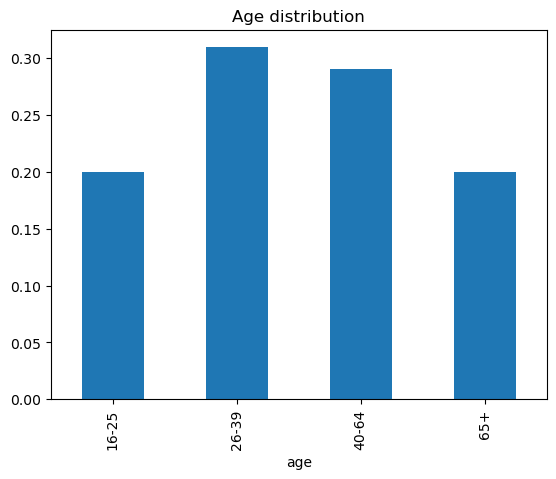

age
16-25    0.143179
26-39    0.105257
40-64    0.044806
65+      0.019524
Name: count, dtype: float64

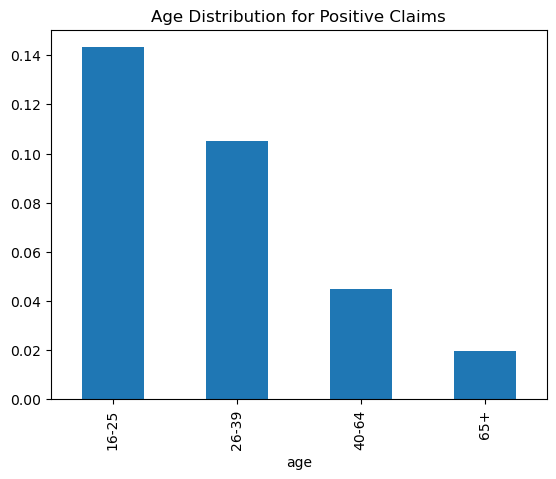

In [42]:
# Comparing age distribution to age distribution when a claim is made
age_order = ["16-25", "26-39", "40-64", "65+"]
eda_data["age"] = pd.Categorical(eda_data["age"], categories=age_order, ordered=True)
age_vals = eda_data["age"].value_counts(sort=False)

display(age_vals / num_rows)

(age_vals / num_rows).plot(kind="bar")
plt.title("Age distribution")
plt.show()

pos_claims_age = eda_data[eda_data["claim_made"] == 1]["age"].value_counts(sort=False)
display(pos_claims_age / num_rows)
(pos_claims_age / num_rows).plot(kind="bar")
plt.title("Age Distribution for Positive Claims")
plt.show()

Show a strong trend in which the older a policyholder is, the less likely to file for a claim

Let's see if we can replicate this trend for the driving_experience feature

driving_experience
0-9y      0.351940
10-19y    0.331414
20-29y    0.210513
30y+      0.106133
Name: count, dtype: float64

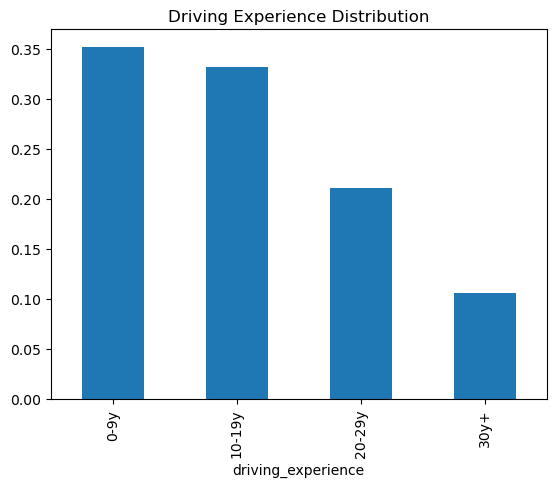

driving_experience
0-9y      0.220776
10-19y    0.079599
20-29y    0.010513
30y+      0.001877
Name: count, dtype: float64

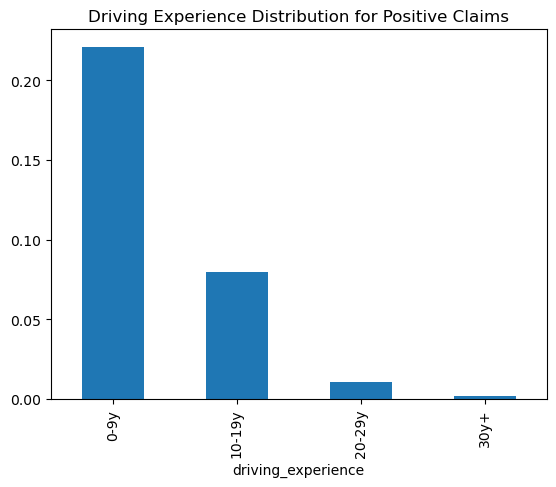

In [44]:
# Comparing driving experience distribution to driving experience distribution when a claim is made
driving_exp_order = ["0-9y", "10-19y", "20-29y", "30y+"] 
eda_data["driving_experience"] = pd.Categorical(eda_data["driving_experience"], categories=driving_exp_order, ordered=True)
driving_exp_vals = eda_data["driving_experience"].value_counts(sort=False)

display(driving_exp_vals/ num_rows)

(driving_exp_vals / num_rows).plot(kind="bar")
plt.title("Driving Experience Distribution")
plt.show()

pos_claims_driving_exp = eda_data[eda_data["claim_made"] == 1]["driving_experience"].value_counts(sort=False)
display(pos_claims_driving_exp / num_rows)
(pos_claims_driving_exp / num_rows).plot(kind="bar")
plt.title("Driving Experience Distribution for Positive Claims")
plt.show()

In [45]:
new = eda_data[eda_data["claim_made"] == 1]["driving_experience"]
new = pd.DataFrame(new)
new.to_csv("C:/Users/julia/OneDrive/Documents/new_data.csv", index=False)

Our most promising category yet:

- Driving experience is even more strongly correlated to a smaller chance in filing a claim than age

- This gives us a better idea of what categorical features are important in determining whether a claim is made or not, and by extension, what our model will find useful

The model aside, the marketing team should push their advertising efforts towards tailoring to those with more driving experience, those older, and maybe a little towards those that are more educated and higher income

#### 2.3 Correlation Matrix

**Goal:** To see how our data's numerical features are correlated with our target feature

In [48]:
# Create a correlation matrix 
numeric_claims = eda_data.select_dtypes(include = [np.number])

corr_matrix = numeric_claims.corr()

claims_corr = corr_matrix["claim_made"].sort_values(ascending = False)
claims_corr = claims_corr.drop("claim_made")

claims_corr = pd.DataFrame(claims_corr)
claims_corr

,claim_made
annual_mileage,0.184371
gender,0.109875
race,0.011535
vehicle_type,-0.008357
num_duis,-0.185693
has_children,-0.228760
is_married,-0.252986
num_speeding_violations,-0.289955
num_past_accidents,-0.306924
credit_score,-0.333810


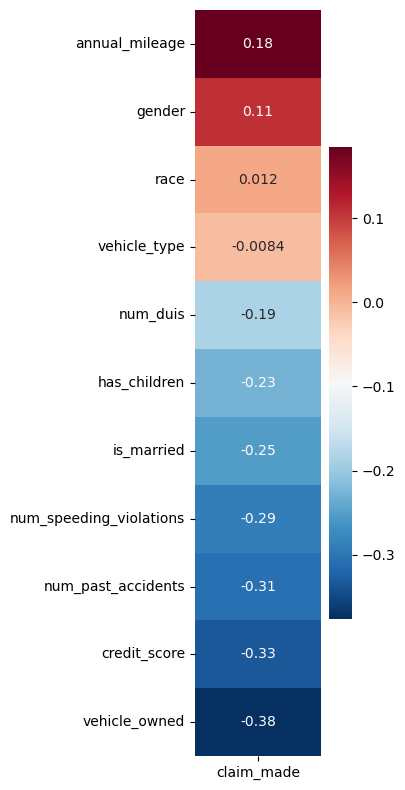

In [49]:
# Creating heatmap of correlation matrix
fig, ax = plt.subplots(figsize=(4, 8))


claims_heatmap = sns.heatmap(claims_corr, cmap = "RdBu_r", annot=True)

plt.tight_layout()

**Note**: These observations are not assuming causation but for possible reasons for the correlation

**Postive Correlations:**
- Overall, not many notable positive correlations
- The data suggest that the more annual mileage, the more likely a claim is made
    -   Driving more naturally leads to more chances to be involved in an incident

**Negative Correlations:**
- Only moderately correlated features
- A claim is less likely to be made if the person has ownership of their vehicle
  - Ownership implies the policyholder has full control on whether to file a claim or not if an accident were to occur, which means they can choose not to file one for smaller accidents in fear of higher premiums
- A higher credit score may suggest they are less likely to make a claim
    - Higher credit scores can indicate low risk behavior, which then leads to less incidents
- The **more** past accidents, the less likely they are to make a claim
  - Seems counterintuitive but may suggest they don't file claims for smaller incidents to avoid higher deductibles and premiums
-  Same goes for DUIs and speeding violations, where a higher count seems to suggest a lower likelihood of filing a claim
    - Another explanation may be because there is simply not a lot of data in the higher end of these features, and claims are generally speaking less likely to be made than not, therefore displaying an inaccurate correlation score

**Negligable Correlations:**
- Vehicle type and race seem to have little to no effect on whether a claim is made

## 3. Data Cleaning and Preprocessing

#### 3.1 Dropping columns and checking for null values

In [52]:
# Creating another copy of X_train to test preprocessing transformations
X_train_raw = X_train.copy()

In [53]:
# Dropping vehicle_type and race columns as they seem to be negligable
X_train_raw.drop(columns=["vehicle_type", "race"], axis=1, inplace=True)

In [54]:
# Check which columns have missing values
X_train_raw.columns[np.sum(X_train_raw.isnull()) != 0]

Index(['credit_score', 'annual_mileage'], dtype='object')

**Overview of Preprocessing Transformations**

Numerical features: SimpleImputer (median) => Feature Scaling

Ordinal categorical features: SimpleImputer (most_frequent) => OrdinalEncoder

Nominal categorical features: SimpleImputer (most_frequent) => OneHotEncoder

Binary Features: SimpleImputer (most_frequent) 

#### 3.2 Imputing features

In [57]:
# Sort columns by type

# Defining numerical columns and dataframe
num_cols = ["credit_score", "annual_mileage", "num_speeding_violations", "num_duis", "num_past_accidents"]
num_df = X_train_raw[num_cols].reset_index(drop=True)

# Defining ordinal categorical columns and dataframe
ord_cat_cols = ["age", "driving_experience", "education_level", "income_level"] 
ord_cat_df = X_train_raw[ord_cat_cols].reset_index(drop=True)

# Defining nominal categorical columns and dataframe
nom_cat_cols = ["postal_code"]
nom_cat_df = X_train_raw[nom_cat_cols].reset_index(drop=True)

# Defining binary columns and dataframe
bin_cols = ["gender", "vehicle_owned", "vehicle_year", "is_married", "has_children"]
bin_df = X_train_raw[bin_cols].reset_index(drop=True)

In [58]:
num_df.isnull().sum()

credit_score               783
annual_mileage             752
num_speeding_violations      0
num_duis                     0
num_past_accidents           0
dtype: int64

In [59]:
# Display df before imputation
num_df.head()

,credit_score,annual_mileage,num_speeding_violations,num_duis,num_past_accidents
0,0.378046,13000.0,2,1,3
1,NaN,14000.0,0,0,0
2,0.590250,12000.0,0,0,0
3,0.747843,13000.0,1,0,0
4,0.730233,11000.0,0,0,0


In [60]:
# Create imputer for numerical features
num_simple_imputer = SimpleImputer(strategy = "median")

# Define function to impute numerical features
def num_col_imputer(data, columns, imputer):
    num_imputer = imputer.fit_transform(data)
    num_imputer_df = pd.DataFrame(num_imputer, columns = columns)
    return num_imputer_df

imputed_num_cols = num_col_imputer(num_df, num_cols, num_simple_imputer)
imputed_num_cols.head()

,credit_score,annual_mileage,num_speeding_violations,num_duis,num_past_accidents
0,0.378046,13000.0,2.0,1.0,3.0
1,0.524603,14000.0,0.0,0.0,0.0
2,0.590250,12000.0,0.0,0.0,0.0
3,0.747843,13000.0,1.0,0.0,0.0
4,0.730233,11000.0,0.0,0.0,0.0


In [61]:
# Checking whether imputer executed properly
imputed_num_cols.isnull().sum()

credit_score               0
annual_mileage             0
num_speeding_violations    0
num_duis                   0
num_past_accidents         0
dtype: int64

**Note:** Null values are only present in *numerical* features in the current dataset used, but imputing these other features (categorical and binary) may be necessary for future data

In [63]:
# Create imputer for ordinal categorical columns
ord_simple_imputer = SimpleImputer(strategy= "most_frequent")

def ord_col_imputer(data, columns, imputer):
    ord_imputer = imputer.fit_transform(data)
    ord_imputer_df = pd.DataFrame(ord_imputer, columns = columns)
    return ord_imputer_df

imputed_ord_cols = ord_col_imputer(ord_cat_df, ord_cat_cols, ord_simple_imputer)

In [64]:
# Create imputer for nominal categorical columns 
# Same process as ordinal imputer, but want to separate the columns for encoding later
nom_simple_imputer = SimpleImputer(strategy= "most_frequent")

def nom_col_imputer(data, columns, imputer):
    nom_imputer = imputer.fit_transform(data)
    nom_imputer_df = pd.DataFrame(nom_imputer, columns = columns)
    return nom_imputer_df

imputed_nom_cols = nom_col_imputer(nom_cat_df, nom_cat_cols, nom_simple_imputer)

In [65]:
# Transform binary categorical columns into having numeric values
# Note: Remember that vehicle_type and race were dropped previously because of lack of correlation
binary_cols = ["gender", "vehicle_year"]

mapping = {"male": 1,
           "female": 0,
           "after 2015": 1,
           "before 2015": 0}

def binarize_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

bin_df = binarize_values(bin_df, binary_cols, mapping)

In [66]:
# Create imputer for binary columns 
bin_simple_imputer = SimpleImputer(strategy= "most_frequent")

def bin_col_imputer(data, columns, imputer):
    bin_imputer = imputer.fit_transform(data)
    bin_imputer_df = pd.DataFrame(bin_imputer, columns = columns)
    return bin_imputer_df

imputed_bin_cols = bin_col_imputer(bin_df, bin_cols, bin_simple_imputer)

#### 3.3 Checking for Normal Distribution in Numerical Features

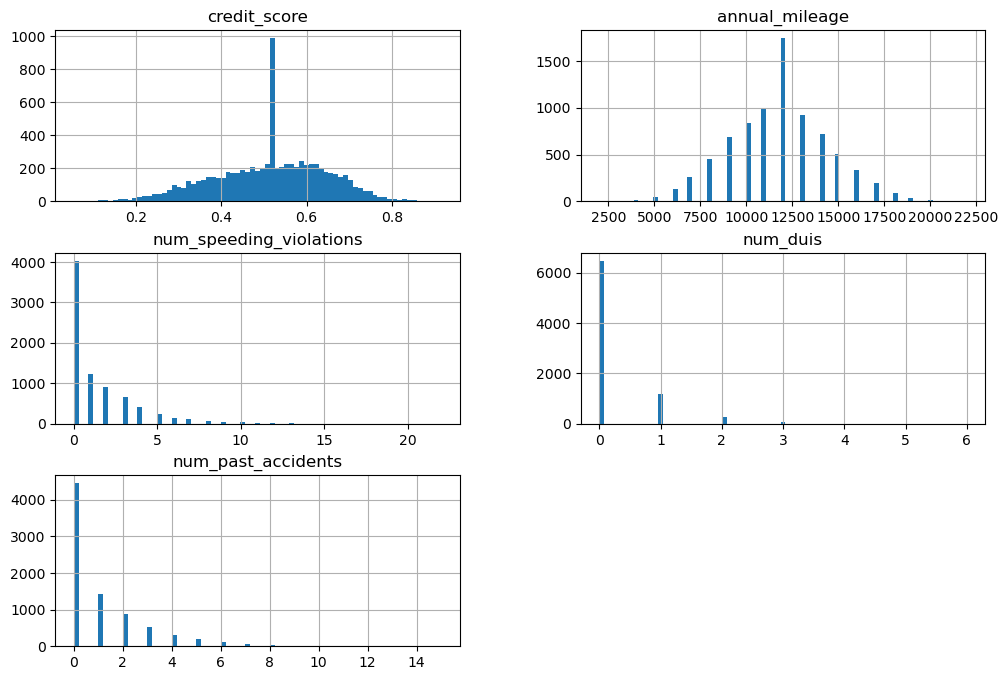

In [68]:
# Creating histograms for numerical columns
imputed_num_cols.hist(bins=75, figsize=(12,8))
plt.show()

**Note:** There is a spike where the median is located for credit_score and annual_mileage because the null values were all assigned the median during the imputation process

**Observations:**
- credit_score and annual_mileage seem to have relatively normal distributions
- num_past_accidents, num_duis, and num_speeding_violations have right skewed distributions

**Goal:** We are trying to ensure these numerical features have a normal distribution or close to one, as it is favorable to certain ML models such as Logistic Regression

Now, we check the skew value of each of feature to see if we need to transform them

-0.268 skew value


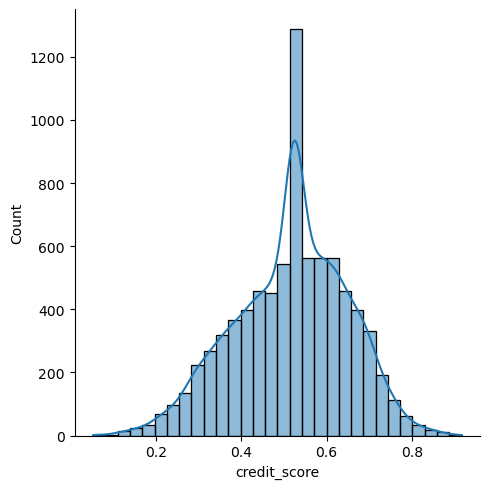

In [70]:
# Checking skew value of credit_score
print(f"{imputed_num_cols['credit_score'].skew():.3f} skew value")
sns.displot(imputed_num_cols["credit_score"], kde=True, bins=30)

credit_score returns an acceptable skew value, indicating a normal distribution, so no changes will be made

0.004 skew value


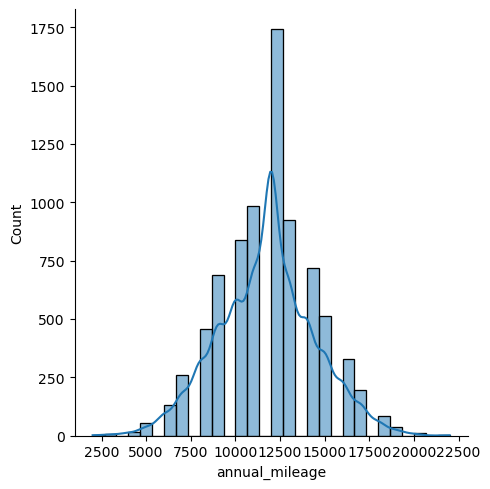

In [72]:
print(f"{imputed_num_cols['annual_mileage'].skew():.3f} skew value")
sns.displot(imputed_num_cols["annual_mileage"], kde=True, bins=30)

Likewise, annual_mileage returns a low skew value, so no changes will be made

past_accidents: 2.147 skew value
duis: 2.764 skew value
speeding_violations: 2.327 skew value


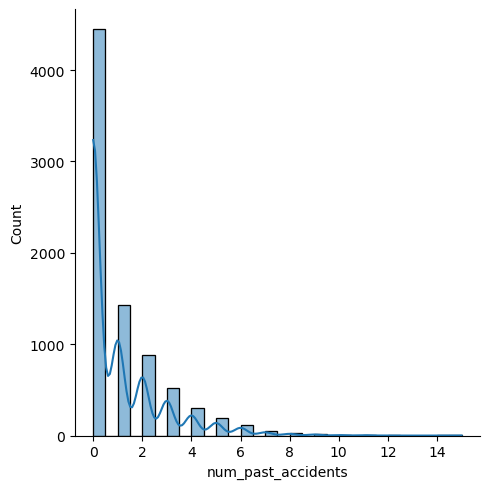

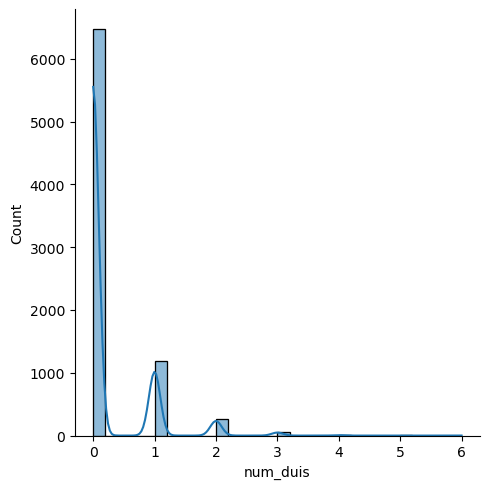

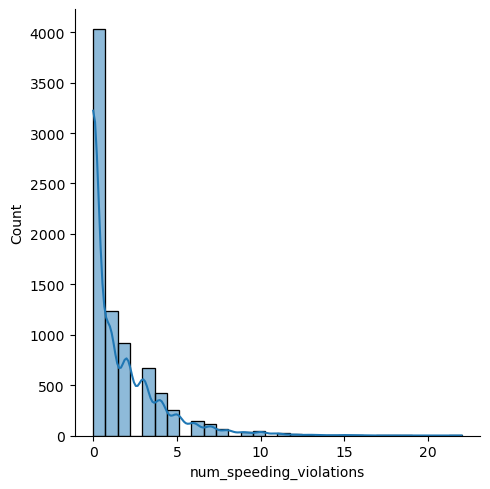

In [74]:
print(f"past_accidents: {imputed_num_cols['num_past_accidents'].skew():.3f} skew value")
sns.displot(imputed_num_cols['num_past_accidents'], kde=True, bins=30)

print(f"duis: {imputed_num_cols['num_duis'].skew():.3f} skew value")
sns.displot(imputed_num_cols["num_duis"], kde=True, bins=30)

print(f"speeding_violations: {imputed_num_cols['num_speeding_violations'].skew():.3f} skew value")
sns.displot(imputed_num_cols["num_speeding_violations"], kde=True, bins=30)

Since num_past_accidents, num_duis, and num_speeding_violations all have high scores for skewness, transformations will be applied to encourage a normal distribution

num_duis sqrt skew value: 1.79


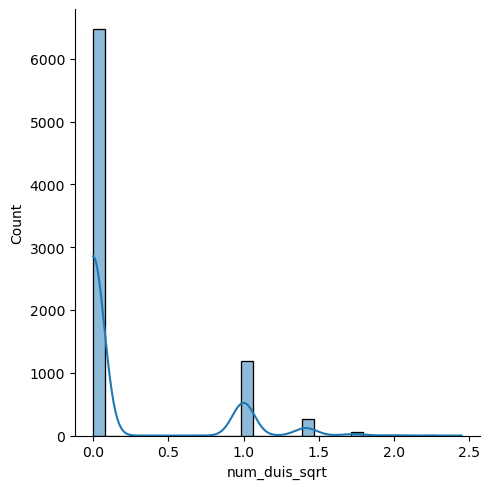

In [76]:
# Start with num_duis feature, which has the highest skew value out of the three

# Apply square root transformation
imputed_num_cols["num_duis_sqrt"] = np.sqrt(imputed_num_cols["num_duis"])

#Print skew value and plot transformation
print(f"num_duis sqrt skew value: {imputed_num_cols['num_duis_sqrt'].skew():.2f}")
sns.displot(imputed_num_cols["num_duis_sqrt"], kde=True, bins=30)

The square root transformation did not perform that well, will experiment with other transformations to see if there's improvement

num_duis log skew value: 1.95


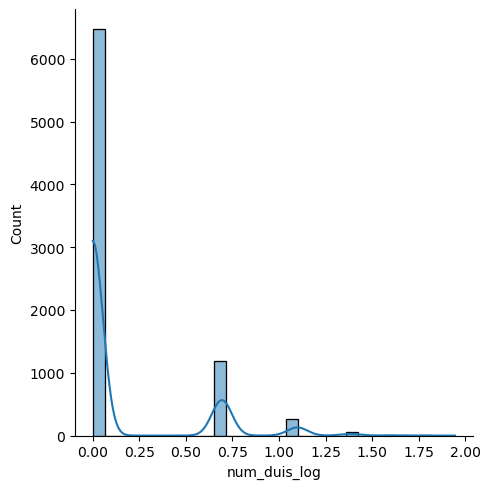

In [78]:
# Apply logorithm transformation instead

# Add 1 to all values in the column so log transformation can work
imputed_num_cols["num_duis_one"] = imputed_num_cols["num_duis"] + 1

imputed_num_cols["num_duis_log"] = np.log(imputed_num_cols["num_duis_one"])
print(f"num_duis log skew value: {imputed_num_cols['num_duis_log'].skew():.2f}")
sns.displot(imputed_num_cols["num_duis_log"], kde=True, bins=30)

The logorithm transformation performed worse than square root transformation, will try BoxCox next

num_duis BoxCox skew value: 1.58


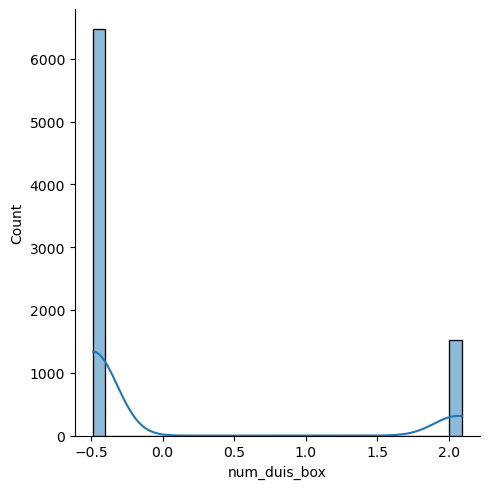

In [80]:
# Trying BoxCox transformation
imputed_num_cols["num_duis_one"] = imputed_num_cols["num_duis"] + 1

imputed_num_cols["num_duis_box"] = power_transform(pd.DataFrame(imputed_num_cols["num_duis_one"]), method="box-cox")
print(f"num_duis BoxCox skew value: {imputed_num_cols['num_duis_box'].skew():.2f}")
sns.displot(imputed_num_cols["num_duis_box"], kde=True, bins=30)

The num_duis feature is also not performing good enough under the BoxCox transformation

Dropping the num_duis feature may be necessary, as the data is too skewed and may do more harm than good for certain ML models

The num_duis feature is also not significant according to our correlation matrix, so let's just drop it for now

In [82]:
# Dropping num_duis column
imputed_num_cols = imputed_num_cols.drop(columns=["num_duis"])

Since BoxCox transformation worked best out of the three, we'll continue to use it for the next two features

past_accidents BoxCox skew value: 0.41


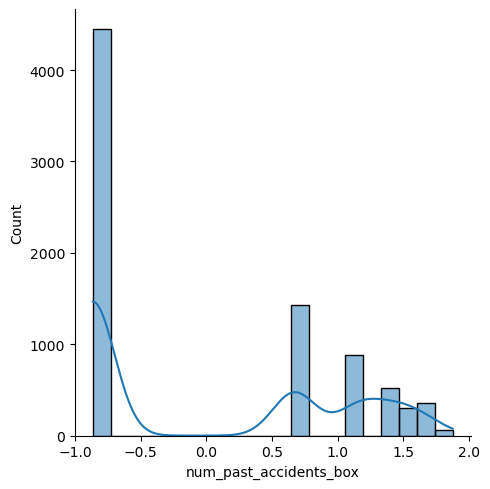

In [84]:
# Since the BoxCox transformation only works on positive values, add 1 to column values
imputed_num_cols["num_past_accidents_one"] = imputed_num_cols["num_past_accidents"] + 1

# Applying transformation and checking skew value 
imputed_num_cols["num_past_accidents_box"] = power_transform(pd.DataFrame(imputed_num_cols["num_past_accidents_one"]), method="box-cox")
print(f"past_accidents BoxCox skew value: {imputed_num_cols['num_past_accidents_box'].skew():.2f}")
sns.displot(imputed_num_cols["num_past_accidents_box"], kde=True, bins=20)

num_duis sqrt skew value: 0.80


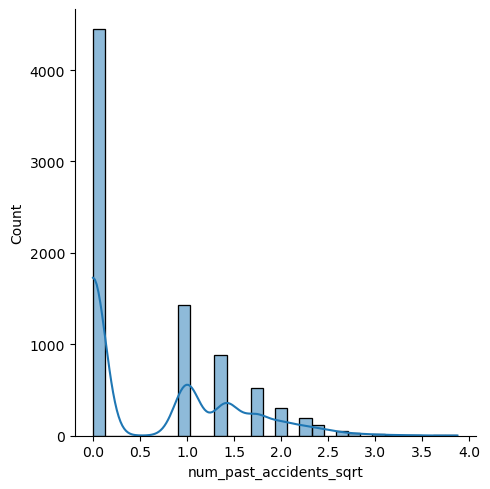

In [85]:
# Double check if square root transformation improves the skew value

imputed_num_cols["num_past_accidents_sqrt"] = np.sqrt(imputed_num_cols["num_past_accidents"])

# Print skew value and plot transformation
print(f"num_duis sqrt skew value: {imputed_num_cols['num_past_accidents_sqrt'].skew():.2f}")
sns.displot(imputed_num_cols["num_past_accidents_sqrt"], kde=True, bins=30)

The square root transformation performed worse

However, the skew value of num_past_accidents improved to a relatively acceptable value using BoxCox, will keep the feature for now

imputed_num_cols BoxCox skew value: 0.30


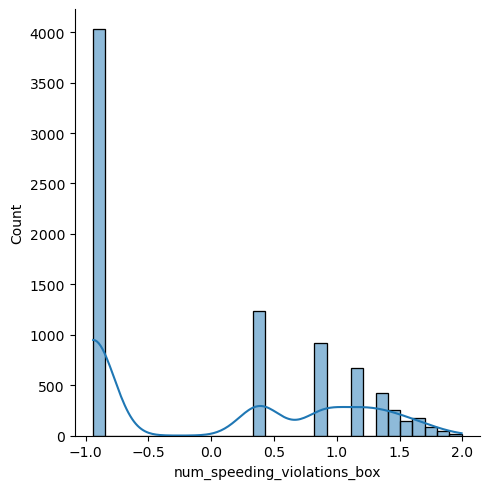

In [87]:
# Apply BoxCox transformation to speeding violations feature
imputed_num_cols["num_speeding_violations_one"] = imputed_num_cols["num_speeding_violations"] + 1

imputed_num_cols["num_speeding_violations_box"] = power_transform(pd.DataFrame(imputed_num_cols["num_speeding_violations_one"]), method="box-cox")
print(f"imputed_num_cols BoxCox skew value: {imputed_num_cols['num_speeding_violations_box'].skew():.2f}")
sns.displot(imputed_num_cols["num_speeding_violations_box"], kde=True, bins=30)

Skew value of num_speeding_violations also improved to an acceptable level, so we'll keep this column for now

In [89]:
# Replacing feature values with updated ones
imputed_num_cols["num_speeding_violations"] = imputed_num_cols["num_speeding_violations_box"]
imputed_num_cols["num_past_accidents"] = imputed_num_cols["num_past_accidents_box"]

In [90]:
# Drop extra columns created during the transformations
imputed_num_cols = imputed_num_cols.drop(columns=["num_duis_sqrt","num_duis_one","num_duis_log","num_duis_box",
                                                  "num_past_accidents_one","num_past_accidents_box",
                                                  "num_past_accidents_sqrt","num_speeding_violations_one",
                                                  "num_speeding_violations_box"])                      

#### 3.4 Feature Scaling Numerical Features

In [92]:
imputed_num_cols.describe()

,credit_score,annual_mileage,num_speeding_violations,num_past_accidents
count,7990.000000,7990.000000,7.990000e+03,7.990000e+03
mean,0.516132,11730.413016,4.802166e-17,9.159687e-17
std,0.131360,2675.772481,1.000063e+00,1.000063e+00
min,0.053358,2000.000000,-9.403561e-01,-8.646870e-01
25%,0.429691,10000.000000,-9.403561e-01,-8.646870e-01
50%,0.524603,12000.000000,-9.403561e-01,-8.646870e-01
75%,0.608239,13000.000000,8.930960e-01,1.153454e+00
max,0.915883,22000.000000,1.993653e+00,1.875114e+00


credit_score and annual_mileage still have outliers

I will use RobustScaler to keep them in the data but not have them affect the scaling method as strongly

In [94]:
# Using RobustScaler to scale numeral columns
scaler = RobustScaler()

num_scaled = scaler.fit_transform(imputed_num_cols)
num_scaled_df = pd.DataFrame(num_scaled, columns=imputed_num_cols.columns)

num_scaled_df.head()

,credit_score,annual_mileage,num_speeding_violations,num_past_accidents
0,-0.820823,0.333333,1.00000,1.115369
1,0.000000,0.666667,0.00000,0.000000
2,0.367674,0.000000,0.00000,0.000000
3,1.250311,0.333333,0.72381,0.000000
4,1.151683,-0.333333,0.00000,0.000000


In [95]:
num_scaled_df.describe()

,credit_score,annual_mileage,num_speeding_violations,num_past_accidents
count,7990.000000,7990.000000,7990.000000,7990.000000
mean,-0.047441,-0.089862,0.512888,0.428457
std,0.735711,0.891924,0.545453,0.495536
min,-2.639319,-3.333333,0.000000,0.000000
25%,-0.531572,-0.666667,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.468428,0.333333,1.000000,1.000000
max,2.191459,3.333333,1.600265,1.357586


#### 3.5 Encoding Categorical Features

In [97]:
# Apply ordinal encoding for ordinal categorical columns

# Define inherent orders for ordinal features
age_order = ["16-25", "26-39", "40-64", "65+"]
driving_exp_order = ["0-9y", "10-19y", "20-29y", "30y+"]
education_level_order = ["none", "high school", "university"]
income_level_order = ["poverty", "working class", "middle class", "upper class"]

# Create encoder using the orders from above and handling unknown values by seting them to -1
ordinal_encoder = OrdinalEncoder(categories=[age_order, driving_exp_order, education_level_order, income_level_order],
                                 handle_unknown='use_encoded_value', unknown_value=-1)

ord_cat_encoded = ordinal_encoder.fit_transform(imputed_ord_cols)
ord_cat_encoded = pd.DataFrame(ord_cat_encoded, columns = imputed_ord_cols.columns)
ord_cat_encoded.head()

,age,driving_experience,education_level,income_level
0,1.0,1.0,0.0,1.0
1,0.0,0.0,0.0,0.0
2,3.0,0.0,2.0,3.0
3,1.0,1.0,2.0,3.0
4,3.0,0.0,1.0,3.0


In [98]:
# Apply OneHotEncoder to nominal categorical columns
one_hot_encoder = OneHotEncoder(sparse_output=False)
nom_cat_encoded = one_hot_encoder.fit_transform(imputed_nom_cols)

# Generates the new feature names after encoding and adds to a list
encoded_columns = one_hot_encoder.get_feature_names_out(imputed_nom_cols.columns)

# Transform the array into a df and use encoded_columns to specify column names
nom_cat_encoded_df = pd.DataFrame(nom_cat_encoded, columns=encoded_columns)
nom_cat_encoded_df.head()

,postal_code_10238,postal_code_21217,postal_code_32765,postal_code_92101
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0


In [99]:
# Combining all transformed dataframes into one
X_train_clean = pd.concat([num_scaled_df, ord_cat_encoded, nom_cat_encoded_df, imputed_bin_cols], axis=1)
X_train_clean.head()

,credit_score,annual_mileage,num_speeding_violations,num_past_accidents,age,driving_experience,education_level,income_level,postal_code_10238,postal_code_21217,postal_code_32765,postal_code_92101,gender,vehicle_owned,vehicle_year,is_married,has_children
0,-0.820823,0.333333,1.00000,1.115369,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000000,0.666667,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.367674,0.000000,0.00000,0.000000,3.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
3,1.250311,0.333333,0.72381,0.000000,1.0,1.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
4,1.151683,-0.333333,0.00000,0.000000,3.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


#### 3.6 Oversampling Data using ADASYN

- As we saw early in the Overview process, we need to use oversampling techniques to balance out the postive claims to match the amount of negative claims

- Oversampling replicates minority datapoints to acheive a more balanced dataset and prevent our ML models from downplaying our positive insurance claims datapoints

- We will use ADASYN (Adaptive Synthetic Sampling), which is an oversampling technique that creates synthetic minority data with a focus on borderline examples

**Note:** We had to implement this after encoding because ADASYN only works on numerical data

In [101]:
adasyn = ADASYN(random_state=42)

X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_clean, y_train)

In [102]:
# Checking balance of data after oversampling
postive_claim_count = 0
negative_claim_count = 0

for i in range(len(y_train_resampled)):
    if y_train_resampled.iloc[i] == 1:
        postive_claim_count += 1
    else:
        negative_claim_count += 1

print(f"Positive claims: {postive_claim_count}")
print(f"Negative claims: {negative_claim_count}")

Positive claims: 5578
Negative claims: 5491


#### 3.7 Checking the VIF

Check the presence of multicollinearity using the variance inflation factor, or VIF

- This is important as strongly/perfectly correlated features lead to difficulties accurately determining the contribution of predictors for certain models

- This could make it difficult to properly predict coefficient estimates for linear based models

- It is especially important to check with our nominal categorical features, as OneHot encoding often leads to perfect multicollinearity between the encoded features

In [104]:
# Creating function to calculate the VIF
def calc_VIF(data):
    vif = pd.DataFrame()
    vif["Features"] = data.columns
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

VIF = calc_VIF(X_train_clean)
VIF

,Features,VIF
0,credit_score,2.052120
1,annual_mileage,1.670946
2,num_speeding_violations,2.609681
3,num_past_accidents,2.077992
4,age,3.007632
5,driving_experience,4.081162
6,education_level,1.515858
7,income_level,3.947644
8,postal_code_10238,8.376414
9,postal_code_21217,1.112425


Our VIF values seem reasonable for the most part

It seems that our only OneHot encoded variable, postal_code, does not have perfect multicollinearity, so we do not have to remove the baseline category

However, since postal_code_10238 still has a relatively high VIF of 8.38, we may need to apply L2 regularization when testing the certain models

In [106]:
# Check whether all features are normally distributed, imputed, and scaled properly
X_train_clean.describe()

,credit_score,annual_mileage,num_speeding_violations,num_past_accidents,age,driving_experience,education_level,income_level,postal_code_10238,postal_code_21217,postal_code_32765,postal_code_92101,gender,vehicle_owned,vehicle_year,is_married,has_children
count,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000,7990.000000
mean,-0.047441,-0.089862,0.512888,0.428457,1.489737,1.070839,1.201502,1.896621,0.697247,0.011014,0.241802,0.049937,0.497997,0.703004,0.304631,0.495620,0.689862
std,0.735711,0.891924,0.545453,0.495536,1.024341,0.991004,0.737696,1.148974,0.459478,0.104374,0.428202,0.217829,0.500027,0.456963,0.460280,0.500012,0.462579
min,-2.639319,-3.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.531572,-0.666667,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,0.468428,0.333333,1.000000,1.000000,2.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.191459,3.333333,1.600265,1.357586,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Creating Model Pipeline

#### 4.1 Finalizing Functions and Variables for the Pipeline

In [109]:
#Finalizing features and their categories
num_attribs = ["credit_score", "annual_mileage"]
boxcox_attribs = ["num_speeding_violations", "num_past_accidents"]
ord_attribs = ["age", "driving_experience", "education_level", "income_level"] 
nom_attribs = ["postal_code"]
bin_attribs = ["vehicle_owned", "is_married", "has_children"]
map_attribs = ["gender", "vehicle_year"]

In [110]:
# Creating functions to use as custom transformations in the pipeline

# Creating an add_constant function to apply to the boxcox data 
def add_constant(data):
    return data + 1

#Make into custom transformer
add_constant_transformer = FunctionTransformer(add_constant, feature_names_out="one-to-one", validate=True)

#Map features in mapping_attribs and turn into transformer for pipeline
mapping = {"male": 1,
           "female": 0,
           "after 2015": 1,
           "before 2015": 0}

def binarize_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

binary_transformer = FunctionTransformer(lambda df: binarize_values(df, map_attribs, mapping), feature_names_out = "one-to-one")

In [111]:
# Defining category orders for our OrdinalEncoder
age_order = ["16-25", "26-39", "40-64", "65+"]
driving_exp_order = ["0-9y", "10-19y", "20-29y", "30y+"]
education_level_order = ["none", "high school", "university"]
income_level_order = ["poverty", "working class", "middle class", "upper class"]
category_order = [age_order, driving_exp_order, education_level_order, income_level_order]

#### 4.2 Creating Pipeline and Training Model

In [113]:
# Creating individual pipelines and using ColumnTransformer to combine and form preprocessing pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), 
    RobustScaler())

boxcox_pipeline = make_pipeline(
        SimpleImputer(strategy="median"), 
        add_constant_transformer,
        PowerTransformer(method="box-cox"),
        RobustScaler())

ord_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=category_order, handle_unknown='use_encoded_value', unknown_value=-1)
)

nom_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),   #drop="first" drops the baseline category to account for multicollinearity
)

bin_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent")
)

map_pipeline = make_pipeline(
    binary_transformer,
    SimpleImputer(strategy="most_frequent")
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("boxcox", boxcox_pipeline, boxcox_attribs),
    ("ord", ord_pipeline, ord_attribs),
    ("nom", nom_pipeline, nom_attribs),
    ("bin", bin_pipeline, bin_attribs),
    ("map", map_pipeline, map_attribs),
], remainder = "drop")

In [114]:
# Training/fitting training set
X_train_prepared = preprocessing.fit_transform(X_train)

In [115]:
# Get feature names
feature_names = preprocessing.get_feature_names_out()
feature_names

array(['num__credit_score', 'num__annual_mileage',
       'boxcox__num_speeding_violations', 'boxcox__num_past_accidents',
       'ord__age', 'ord__driving_experience', 'ord__education_level',
       'ord__income_level', 'nom__postal_code_10238',
       'nom__postal_code_21217', 'nom__postal_code_32765',
       'nom__postal_code_92101', 'bin__vehicle_owned', 'bin__is_married',
       'bin__has_children', 'map__gender', 'map__vehicle_year'],
      dtype=object)

## 5. Model Testing

#### 5.1 Exploring and Testing Different Models

In [117]:
# Defining models we want to try
# Adding l2 regularization to applicable models
models = [
    ("Log Reg", LogisticRegression(penalty="l2", solver="liblinear")),
    ("KNN", KNeighborsClassifier()), 
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(random_state=42)),  
    ("Linear SVM", LinearSVC(random_state=42, max_iter=1000, penalty="l2")),  
    ("AdaBoost", AdaBoostClassifier(random_state=42, algorithm="SAMME")), 
    ("Gradient Boost", GradientBoostingClassifier(random_state=42)),  
    ("Bagging", BaggingClassifier(random_state=42))  
]    

In [118]:
# Use cross-validation to evaluate the various models' accuracies
kf = KFold(n_splits=5, shuffle=True, random_state=42)

model_results={}

for model_name, model in models:
    try:
        pipeline = ImbPipeline([
            ("adasyn", ADASYN(random_state=42)),
            ("model", model)
        ])
        acc_scores = cross_val_score(pipeline, X_train_prepared, y_train, cv=kf, scoring="accuracy")
        model_results[model_name] = acc_scores
    except Exception as e:
        print(f"Error with model {model_name}: {e}")
        
model_accuracy_df = pd.DataFrame(model_results)

In [119]:
# Accuracy amongst the models within different folds
model_accuracy_df

,Log Reg,KNN,Decision Tree,Random Forest,Linear SVM,AdaBoost,Gradient Boost,Bagging
0,0.831665,0.777847,0.783479,0.841677,0.829161,0.838548,0.849812,0.812891
1,0.819149,0.777222,0.773467,0.826658,0.816646,0.833542,0.843554,0.809762
2,0.803504,0.769712,0.777222,0.819149,0.798498,0.820401,0.825407,0.814143
3,0.839800,0.764706,0.791615,0.849812,0.836671,0.842303,0.854193,0.829787
4,0.821026,0.762829,0.779725,0.832916,0.821026,0.824155,0.835419,0.823529


In [120]:
# Average accuracy for the different models
print(round(model_accuracy_df.mean(), 3))

Log Reg           0.823
KNN               0.770
Decision Tree     0.781
Random Forest     0.834
Linear SVM        0.820
AdaBoost          0.832
Gradient Boost    0.842
Bagging           0.818
dtype: float64


Text(0.5, 1.0, 'Accuracy Score for Different Models')

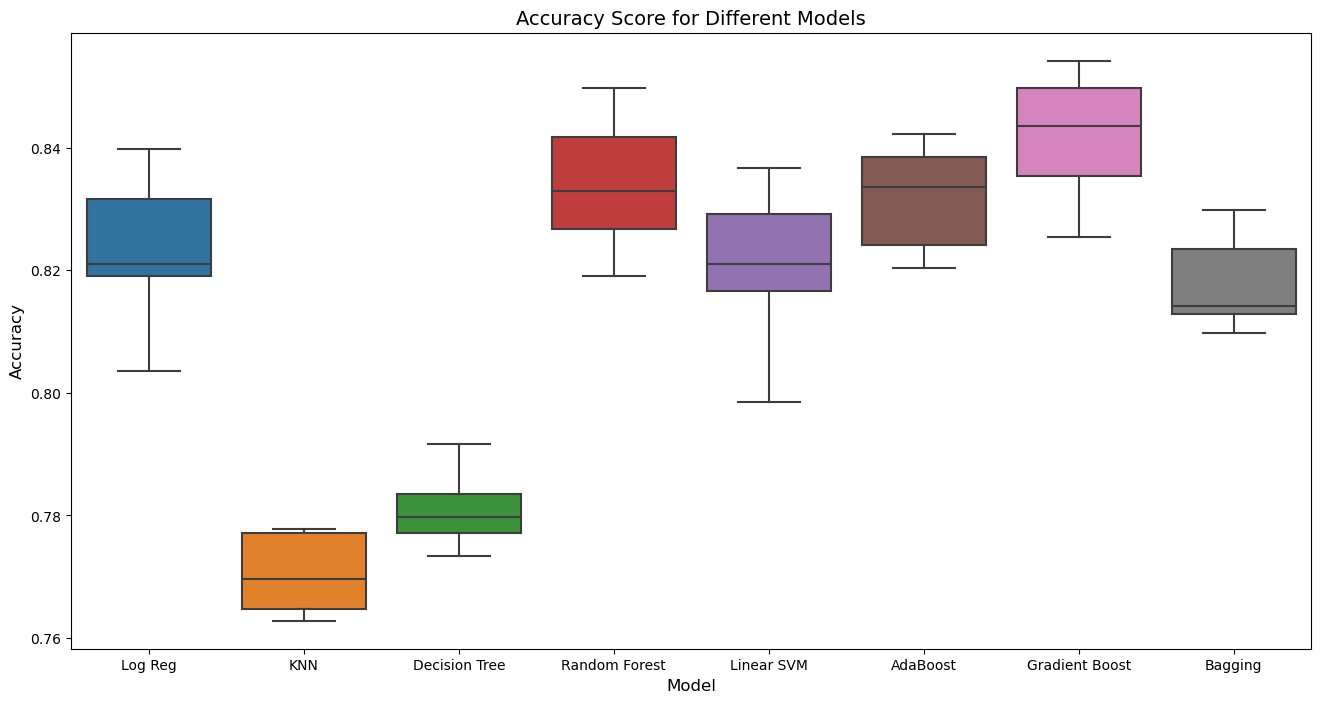

In [121]:
# Plotting cross-validation results of the models as boxplots
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(model_accuracy_df)

ax.set_xlabel("Model", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy Score for Different Models", fontsize=14)

We'll decide to move forward with Random Forest, AdaBoost, Gradient Boost 

These models were chosen on the basis of their higher average and median accuracy, as well as reasonable amount of variability between folds

#### 5.2 Tuning Hyperparameters 

We'll use RandomSearchCV to find the best set of hyperparameters for each model

In [124]:
# Hyperparameter tuning for GradientBoost model
# Defining hyperparameters and value ranges we are testing
param_dist_gboost = {
    "model__n_estimators": [100, 200, 300],          
    "model__learning_rate": [0.01, 0.1, 0.05],         
    "model__max_depth": [3, 4, 5],               
    "model__min_samples_split": [2, 5, 10],          
    "model__min_samples_leaf": [1, 2, 4],            
    "model__subsample": [0.8, 1.0],                    
    "model__max_features": ["auto", "sqrt", "log2"],   
    "model__random_state": [42]                        
}

pipeline_gboost = ImbPipeline([
    ("adasyn", ADASYN(random_state=42)),                  
    ("model", GradientBoostingClassifier(random_state=42)) 
])
random_search_gboost = RandomizedSearchCV(estimator=pipeline_gboost, 
                                          param_distributions=param_dist_gboost, 
                                          n_iter=50,  
                                          cv=5, 
                                          scoring="accuracy", 
                                          n_jobs=-1, 
                                          verbose=2,
                                          random_state=42)

random_search_gboost.fit(X_train_prepared, y_train)

# Output the best parameters and score
print("Best parameters for Gradient Boosting (RandomizedSearchCV):", random_search_gboost.best_params_)
print("Best score for Gradient Boosting (RandomizedSearchCV):", random_search_gboost.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Gradient Boosting (RandomizedSearchCV): {'model__subsample': 1.0, 'model__random_state': 42, 'model__n_estimators': 300, 'model__min_samples_split': 10, 'model__min_samples_leaf': 4, 'model__max_features': 'auto', 'model__max_depth': 4, 'model__learning_rate': 0.05}
Best score for Gradient Boosting (RandomizedSearchCV): 0.8469336670838548


In [125]:
# Hyperparameter tuning for RandomForest model
# Defining hyperparameters and value ranges we are testing
param_dist_rf = {
    "model__n_estimators": [100, 200, 500],           
    "model__max_depth": [None, 10, 20, 30],           
    "model__min_samples_split": randint(2, 11),        
    "model__min_samples_leaf": randint(1, 5),         
    "model__max_features": ["auto", "sqrt", "log2"],  
    "model__bootstrap": [True, False],                
    "model__criterion": ["gini", "entropy"],          
    "model__random_state": [42]                        
}

# Creating pipeline to include both our oversampling method (ADASYN) and our model (RandomForestClassifier)
pipeline_rf = ImbPipeline([
    ("adasyn", ADASYN(random_state=42)),                  
    ("model", RandomForestClassifier(random_state=42))  
])

random_search_rf = RandomizedSearchCV(estimator=pipeline_rf, 
                                      param_distributions=param_dist_rf, 
                                      n_iter=50,  
                                      cv=5, scoring="accuracy", 
                                      n_jobs=-1, verbose=2, random_state=42)

random_search_rf.fit(X_train_prepared, y_train)

# Output the best parameters and score
print("Best parameters for RandomForest (RandomizedSearchCV):", random_search_rf.best_params_)
print("Best score for RandomForest (RandomizedSearchCV):", random_search_rf.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for RandomForest (RandomizedSearchCV): {'model__bootstrap': False, 'model__criterion': 'entropy', 'model__max_depth': 20, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 100, 'model__random_state': 42}
Best score for RandomForest (RandomizedSearchCV): 0.8416770963704631


In [126]:
# Hyperparameter tuning for our AdaBoost model
# Defining hyperparameters and value ranges we are testing
param_dist_adaboost = {
    "model__n_estimators": [50, 100, 200],             
    "model__learning_rate": [0.01, 0.1, 0.5, 1.0],   
    "model__algorithm": ["SAMME", "SAMME.R"],         
    "model__random_state": [42]                        
}

# Creating pipeline to include both our oversampling method (ADASYN) and our model (AdaBoostClassifier)
pipeline_adaboost = ImbPipeline([
    ("adasyn", ADASYN(random_state=42)),                
    ("model", AdaBoostClassifier(random_state=42))      
])

random_search_adaboost = RandomizedSearchCV(estimator=pipeline_adaboost, 
                                            param_distributions=param_dist_adaboost, 
                                            n_iter=50,  
                                            cv=5, 
                                            scoring="accuracy", 
                                            n_jobs=-1, 
                                            verbose=2,
                                            random_state=42)

random_search_adaboost.fit(X_train_prepared, y_train)

# Output the best parameters and score
print("Best parameters for AdaBoost (RandomizedSearchCV):", random_search_adaboost.best_params_)
print("Best score for AdaBoost (RandomizedSearchCV):", random_search_adaboost.best_score_) 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for AdaBoost (RandomizedSearchCV): {'model__random_state': 42, 'model__n_estimators': 200, 'model__learning_rate': 1.0, 'model__algorithm': 'SAMME.R'}
Best score for AdaBoost (RandomizedSearchCV): 0.8455569461827285


#### 5.3 Feature Selection

Now that we found optimal hyperparameters for our three models, we can explore the most important features of each model and also remove features accordingly

In [128]:
# Training GradientBoost model using GridSearchCV's best hyperparameters
gboost = ImbPipeline([
    ("adasyn", ADASYN(random_state=42)),
    ("gboost", GradientBoostingClassifier(subsample=1.0, random_state=42, 
                                          n_estimators=300, min_samples_split=10, 
                                          min_samples_leaf=4, max_features="auto", 
                                          max_depth=4, learning_rate=0.05))
     ])

In [129]:
# Training GradientBoost based on best parameters
gboost.fit(X_train_prepared, y_train)

# Accessing the trained GradientBoostingClassifier
gb_model = gboost.named_steps["gboost"]

# Get feature importances from the trained GradientBoostingClassifier
gb_feature_importances = gb_model.feature_importances_

# Plot the importance of each feature in our GradientBoost model
gb_feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": gb_feature_importances
}).sort_values(by="Importance", ascending=False)

print(gb_feature_importance_df.head)

<bound method NDFrame.head of                             Feature  Importance
5           ord__driving_experience    0.403359
16                map__vehicle_year    0.154515
12               bin__vehicle_owned    0.130096
9            nom__postal_code_21217    0.062728
1               num__annual_mileage    0.050655
8            nom__postal_code_10238    0.043619
15                      map__gender    0.040340
13                  bin__is_married    0.023843
3        boxcox__num_past_accidents    0.018452
0                 num__credit_score    0.018304
2   boxcox__num_speeding_violations    0.017806
4                          ord__age    0.010878
14                bin__has_children    0.010383
6              ord__education_level    0.006625
7                 ord__income_level    0.006171
10           nom__postal_code_32765    0.001346
11           nom__postal_code_92101    0.000878>


In [130]:
# Training RandomForest model using GridSearchCV's best hyperparameters
rf = ImbPipeline([
    ("adasyn", ADASYN(random_state=42)),
    ("random_forest", RandomForestClassifier(bootstrap=False, criterion= "entropy", 
                                             max_depth=20, max_features="log2", 
                                             min_samples_leaf=4, min_samples_split=10, 
                                             n_estimators=100, random_state=42))
     ])

In [131]:
# Plot the importance of each feature in our RandomForest model
rf.fit(X_train_prepared, y_train)

rf_model = rf.named_steps["random_forest"]

rf_feature_importances = rf_model.feature_importances_

rf_feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": rf_feature_importances
}).sort_values(by="Importance", ascending=False)

print(rf_feature_importance_df.head)

<bound method NDFrame.head of                             Feature  Importance
5           ord__driving_experience    0.180337
16                map__vehicle_year    0.120079
12               bin__vehicle_owned    0.099716
4                          ord__age    0.076892
3        boxcox__num_past_accidents    0.071103
0                 num__credit_score    0.070741
2   boxcox__num_speeding_violations    0.068300
1               num__annual_mileage    0.064241
15                      map__gender    0.045405
8            nom__postal_code_10238    0.041286
9            nom__postal_code_21217    0.038886
7                 ord__income_level    0.035344
13                  bin__is_married    0.027972
6              ord__education_level    0.021488
14                bin__has_children    0.018262
10           nom__postal_code_32765    0.013719
11           nom__postal_code_92101    0.006228>


In [132]:
# Training AdaBoost model using GridSearchCV's best hyperparameters
adaboost = ImbPipeline([
    ("adasyn", ADASYN(random_state=42)),
    ("adaboost", AdaBoostClassifier(algorithm= "SAMME.R", learning_rate=1.0, 
                                    n_estimators=200, random_state=42))
     ])

In [133]:
# Plotting the importance of each feature in AdaBoost model
adaboost.fit(X_train_prepared, y_train)

ad_model = adaboost.named_steps["adaboost"]

ad_feature_importances = ad_model.feature_importances_

ad_feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": ad_feature_importances
}).sort_values(by="Importance", ascending=False)

print(ad_feature_importance_df)

                            Feature  Importance
3        boxcox__num_past_accidents       0.210
1               num__annual_mileage       0.170
6              ord__education_level       0.100
2   boxcox__num_speeding_violations       0.095
15                      map__gender       0.080
16                map__vehicle_year       0.075
13                  bin__is_married       0.070
14                bin__has_children       0.055
0                 num__credit_score       0.045
5           ord__driving_experience       0.035
4                          ord__age       0.030
12               bin__vehicle_owned       0.010
7                 ord__income_level       0.010
9            nom__postal_code_21217       0.005
11           nom__postal_code_92101       0.005
8            nom__postal_code_10238       0.005
10           nom__postal_code_32765       0.000


**Interpretation of Important Features:**

- It seems that driving_experience, vehicle_year, vehicle_owned were the top 3 features for both our GradientBoost and RandomForest model

- GradientBoost's and RandomForest's most important features aligned pretty similarly overall, though AdaBoost's features were sometimes quite different than the two

- Overall postal_code and income_level showed low importance for all three models (except for postal code 21217 for GradientBoost)

Since this dataset does not have many features, I manually picked which features I wanted to drop rather than using scikit's SelectFromModel transformer to do so. 

I will remove **postal_code** and **income_level**, which I selected by combining common features that were in the bottom half of each of the model's lists

In [135]:
# List of negligable features
unimportant_features = ["postal_code", "income_level"]

# Dropping negligable features from training and test set
X_train_new = X_train.drop(columns=unimportant_features)
X_test_new = X_test.drop(columns=unimportant_features)
X_train_new.head()

,age,gender,race,driving_experience,education_level,credit_score,vehicle_owned,vehicle_year,is_married,has_children,annual_mileage,vehicle_type,num_speeding_violations,num_duis,num_past_accidents
1310,26-39,male,majority,10-19y,none,0.378046,0.0,after 2015,0.0,0.0,13000.0,sedan,2,1,3
156,16-25,female,majority,0-9y,none,NaN,0.0,before 2015,0.0,0.0,14000.0,sedan,0,0,0
3581,65+,female,majority,0-9y,university,0.590250,1.0,after 2015,1.0,1.0,12000.0,sedan,0,0,0
3322,26-39,female,majority,10-19y,university,0.747843,1.0,before 2015,1.0,1.0,13000.0,sedan,1,0,0
8547,65+,male,majority,0-9y,high school,0.730233,1.0,before 2015,0.0,0.0,11000.0,sedan,0,0,0


#### 5.4 Re-training Models with Updated Features

Now that we updated our features to reduce noise, we will re-test our models to see if removing these 3 features improved performance

In [137]:
# Updated columns for preprocessing pipeline
new_num_attribs = ["credit_score", "annual_mileage"]
new_boxcox_attribs = ["num_speeding_violations", "num_past_accidents"]
new_ord_attribs = ["age", "driving_experience", "education_level"] 
new_nom_attribs = []
new_bin_attribs = ["vehicle_owned", "is_married", "has_children"]
new_map_attribs = ["gender", "vehicle_year"]

In [138]:
# Updated ordinal category specifications (without income_order)
new_category_order = [age_order, driving_exp_order, education_level_order]

In [139]:
# Updated ordinal pipeline
new_ord_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=new_category_order, handle_unknown="use_encoded_value", unknown_value=-1)
)

In [140]:
# Updated preprocessing pipeline
new_preprocessing = ColumnTransformer([
    ("num", num_pipeline, new_num_attribs),
    ("boxcox", boxcox_pipeline, new_boxcox_attribs),
    ("ord", new_ord_pipeline, new_ord_attribs),
    ("nom", nom_pipeline, new_nom_attribs),
    ("bin", bin_pipeline, new_bin_attribs),
    ("map", map_pipeline, new_map_attribs),
], remainder = "drop")

In [141]:
# Retraining our GBoost model
kf_new = KFold(n_splits=5, shuffle=True, random_state=42)
adasyn = ADASYN(n_neighbors=3, sampling_strategy=0.8, random_state=42)

gboost_pipeline_train = ImbPipeline([
    ("preprocessor", new_preprocessing),  
    ("adasyn", adasyn),
    ("gboost", gboost)
])

# Accuracy while using cross-Validation
gb_cross_val_scores = cross_val_score(gboost_pipeline_train, X_train_new, y_train, cv=kf_new, n_jobs=-1)
print(f"Mean cross-validation accuracy: {gb_cross_val_scores.mean():.4f}")

Mean cross-validation accuracy: 0.8335


Score before feature removal: 0.8469

In [143]:
# Retraining our Randomforest model
rf_pipeline_train = ImbPipeline([
    ("preprocessor", new_preprocessing),  
    ("adasyn", adasyn),
    ("randomforest", rf)
])

# Accuracy while using cross-Validation
rf_cross_val_scores = cross_val_score(rf_pipeline_train, X_train_new, y_train, cv=kf_new, n_jobs=-1)
print(f"Mean cross-validation accuracy: {rf_cross_val_scores.mean():.4f}")

Mean cross-validation accuracy: 0.8272


Score before feature removal: 0.8417

In [145]:
# Retraining our AdaBoost model
ada_pipeline_train = ImbPipeline([
    ("preprocessor", new_preprocessing),  
    ("adasyn", adasyn),
    ("ad", adaboost)
])

# Accuracy while using cross-Validation
ad_cross_val_scores = cross_val_score(ada_pipeline_train, X_train_new, y_train, cv=kf_new, n_jobs=-1)
print(f"Mean cross-validation accuracy: {ad_cross_val_scores.mean():.4f}")

Mean cross-validation accuracy: 0.8277


Score before feature removal: 0.8456

- It seems that removing "low importance" features actually lowered performance in all three of our models

- We will keep the original set of features then

Next, we can try using an ensemble method to try to improve model performance

#### 5.5 Testing Ensemble Method

Ensemble methods are used by combining multiple models together to hopefully form an even better predictor

We will be using a Voting Classifier to join our models together, which uses the highest average probability between the models used for its prediction

In [149]:
# Combining the performance of our GradientBoost, RandomForest, and AdaBoost model using Voting Classifier
adasyn_ens = ADASYN(n_neighbors=3, sampling_strategy=0.8, random_state=42)
kf_ens = KFold(n_splits=5, shuffle=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("gb", gboost),
        ("rf", rf),
        ("ad", adaboost)
    ],
    voting="soft" 
)

# Creating pipeline with preprocessing, oversampling, and voting ensemble method
ensemble_pipeline = ImbPipeline([
    ("preprocessing", preprocessing),  
    ("adasyn", adasyn_ens),  
    ("voting_clf", voting_clf) 
])

ensemble_pipeline.fit(X_train, y_train)

# Accuracy while using cross-Validation
cross_val_scores = cross_val_score(ensemble_pipeline, X_train, y_train, cv=kf_ens, n_jobs=-1)
print(f"Mean cross-validation accuracy: {cross_val_scores.mean():.4f}")

Mean cross-validation accuracy: 0.8463


Seems that the ensemble method actually performed marginally worse than our GradientBoost model by itself

We'll move forward with the GradientBoost model with its adjusted hyperparameters from RandomSearchCV to finally test on our test set

#### 5.6 Evaluating on Test Set

In [152]:
# Creating instance of GBoost model with updated parameters
gboost_final = GradientBoostingClassifier(subsample=1.0, random_state=42, 
                                          n_estimators=300, min_samples_split=10, 
                                          min_samples_leaf=4, max_features="auto", 
                                          max_depth=4, learning_rate=0.05)


kf_final = KFold(n_splits=5, shuffle=True, random_state=42)
adasyn_final = ADASYN(n_neighbors=3, sampling_strategy=0.8, random_state=42)

final_gboost_pipeline = ImbPipeline([
    ("preprocessor", preprocessing),  
    ("adasyn", adasyn),
    ("gboost", gboost_final)
])

final_gboost_pipeline.fit(X_train, y_train)

# Accuracy while using cross-Validation
gb_final_cross_val_scores = cross_val_score(final_gboost_pipeline, X_train, y_train, cv=kf_final, n_jobs=-1)
print(f"Mean cross-validation accuracy: {gb_final_cross_val_scores.mean():.4f}")

Mean cross-validation accuracy: 0.8481


After cross validation, our GradientBoostingClassifier resulted in a 84.81% accuracy score, which is better than anything else we have tried

We will now evaluate our trained model on our test set

#### 5.7 Test Set Results

In [155]:
y_pred_test = final_gboost_pipeline.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy of Final GradientBoost model on Test Set: {accuracy_test:.4f}")

Accuracy of Final GradientBoost model on Test Set: 0.8564


Nice! Our test set finished with an accuracy of just around 85.6%

Our test accuracy and training accuracy are very similar indicating that it should generalize pretty well to new data

Finally, I'll create a confusion matrix to better visualize our model's performance on the test set

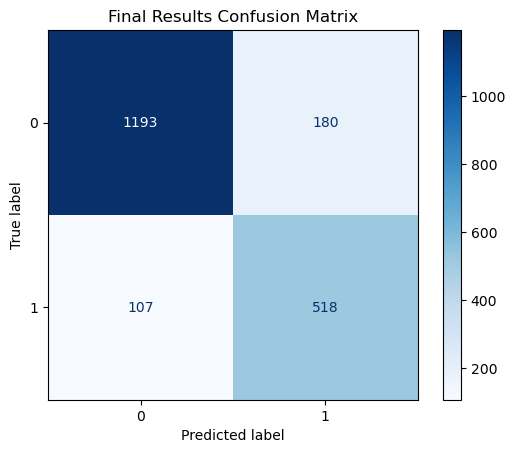

In [157]:
# Creating confusion matrix instance
cm = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Final Results Confusion Matrix")
plt.show()

**Key:**

True Negatives: 1193 policyholders were correctly predicted as not having made a claim (actual 0, predicted 0)

False Positives (Type I error): 180 policyholders were incorrectly predicted as having made a claim (actual 0, predicted 1)

False Negatives (Type II error): 107 policyholders actually made a claim, but the model predicted that no claim would be made (actual 1, predicted 0)

True Positives: 518 policyholders were correctly predicted as having made a claim (actual 1, predicted 1)

**Insights:**

- The model is well balanced, with a strong performance in predicting positive cases (83.3%) and a respectable precision score (74.7%)

- Overall, the model handles both the "no claim" and "claim" predictions fairly well
  - This means our oversampling did a good job in preventing the model from biasing towards "no claim" simply because of the class imbalance

## 6. Conclusion

Ultimately, our Gradient Boosting Classifier performed the best, predicting whether a claim was made or not with 85.6% accuracy, with relatively balanced errors between Type I and Type II given the distribution. Through our exploratory analysis and our model, we were able to capture parameters, like driving_experience and vehicle_year, that consistently showed a stronger correlation with our target feature. With these results, we can support underwriter's in their risk assessment in applicants and refine pricing strategies for policyholders given certain traits. 

**Possible Improvements and Limitations:**
- The actual data for certain parameters were quite limiting; vehicle year, one of our strongest parameters, was limited to be a binary feature with only before 2015 and after 2015 as possible values
  - Specific vehicle years, or even the addition of car brands, would be more realistic data for our model to work on in the real world
  - Same goes for features such as age, vehicle type, and driving experience, which were restricted to the categories given by the original data
- I could have picked a wider variety of models to work with
  - There are a lot of similarities between the Gradient Boosting and AdaBoost models, so it would have been better to pick something like a regression model to move forward with for one of the two, especially for the ensemble method portion of the project
- Retrieving more data for the model to be trained on
  - For the purpose of improving generalization and application in the real world, 10,000 instances is not a lot of data to train the model on, and is a limiting factor in this project
- This project does not address possible 
ocurencse of insurance fraud, which may skew certain instance in the datas